In [350]:
# Импортируем все необходимые для работы библиотеки и инструменты

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os

from pandas import Series

from sklearn import metrics 
from sklearn.feature_selection import f_classif, mutual_info_classif

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score 

%matplotlib inline

In [351]:
# обязательно фиксируем random seed, для воспроизводимости эксперимента
random_seed = 42
pd.set_option('display.max_columns', None)

In [352]:
# опишем функцию для поиска выбросов
def outlier_detect(data, column):
    Q1 = np.percentile(column, 25)
    Q3 = np.percentile(column, 75)
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    lower_number = len(data[column<lower_range])
    upper_number = len(data[column>upper_range])
    print('Lower Range:', lower_range,
          'Upper Range:', upper_range,
          'Lower Outliers:', lower_number,
          'Upper Outliers:', upper_number, 
          sep='\n')

In [353]:
# опишем функцию для визуализации матрицы ошибок
def show_confusion_matrix(y_true, y_pred):
    color_text = plt.get_cmap('PuBu')(0.95)
    class_names = ['Default', 'Non-Default']
    cm = confusion_matrix(y_true, y_pred)
    cm[0,0], cm[1,1] = cm[1,1], cm[0,0]
    df = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), title="Confusion Matrix")
    ax.title.set_fontsize(15)
    sns.heatmap(df, square=True, annot=True, fmt="d", linewidths=1, cmap="PuBu")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=12)
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor", fontsize=12)
    ax.set_ylabel('Predicted Values', fontsize=14, color = color_text)
    ax.set_xlabel('Real Values', fontsize=14, color = color_text)
    b, t = plt.ylim()
    plt.ylim(b+0.5, t-0.5)
    fig.tight_layout()
    plt.show()

In [354]:
# опишем функцию для визуализации метрик для логистической регрессии
def all_metrics(y_true, y_pred, y_pred_prob):
    dict_metric = {}
    P = np.sum(y_true==1)
    N = np.sum(y_true==0)
    TP = np.sum((y_true==1)&(y_pred==1))
    TN = np.sum((y_true==0)&(y_pred==0))
    FP = np.sum((y_true==0)&(y_pred==1))
    FN = np.sum((y_true==1)&(y_pred==0))
    
    dict_metric['Positive, P'] = [P,'default']
    dict_metric['Negative, N'] = [N,'non-default']
    dict_metric['True Positive, TP'] = [TP,'correctly identified default']
    dict_metric['True Negative, TN'] = [TN,'correctly identified non-default']
    dict_metric['False Positive, FP'] = [FP,'incorrectly identified default']
    dict_metric['False Negative, FN'] = [FN,'incorrectly identified non-default']
    dict_metric['Accuracy'] = [accuracy_score(y_true, y_pred),'Accuracy=(TP+TN)/(P+N)']
    dict_metric['Precision'] = [precision_score(y_true, y_pred),'Precision = TP/(TP+FP)'] 
    dict_metric['Recall'] = [recall_score(y_true, y_pred),'Recall = TP/P']
    dict_metric['F1-score'] = [f1_score(y_true, y_pred),'Harmonical mean of Precision и Recall']
    dict_metric['ROC_AUC'] = [roc_auc_score(y_true, y_pred_prob),'ROC AUC Score']    

    temp_df = pd.DataFrame.from_dict(dict_metric, orient='index', columns=['Value', 'Description'])
    display(temp_df)   

In [355]:
# импортируем наши датасеты
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# и сразу посмотрим что представляют из себя данные в них
data_train.info()
display(data_train.head())
data_test.info()
display(data_test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [356]:
# объединм датасеты
data_train['sample'] = 1
data_test['sample'] = 0
data = data_train.append(data_test, sort=False).reset_index(drop=True)

### Предподготвка данных

In [357]:
# посмотрим на данные
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,1


In [358]:
# посмотрим на пропущенные значения
data.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
sample                  0
dtype: int64

* app_date - date of request, time variable, requires processing.
* education - level of education, categorical variable, requires processing and missing values correction.
* sex - binary variable, requires processing.
* age - continuous variable, requires processing.
* car - car availability, binary variable, requires processing.
* car_type - foreign-made car availability, binary variable, requires processing.
* decline_app_cnt - number of rejected requests, continuous variable.
* good_work - flag of a well-paid job, binary variable.
* score_bki - BKI (credit reporting agency) internal score, continuous variable.
* bki_request_cnt - number of requests to the BKI (credit reporting agency), continuous variable.
* region_rating - rating of the region, categorical variable.
* home_address - home address categorizer, categorical variable.
* work_address - work address categorizer, categorical variable.
* income - client's income level, continuous variable. 
* sna - level of connection with another clients, categorical variable.
* first_time - how long the client has been in the database, categorical variable.
* foreign_passport - passport availability, binary variable, requires processing.
* default - default in the past, binary target variable.  

In [359]:
# сгруппируем признаки по типу признака, временной выделим отдельно от остальных
time_cols = ['app_date']
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income']

In [360]:
# посмотрим на пропущенные значение  в признаке education
data['education'].value_counts(dropna = False)

SCH    57998
GRD    34768
UGR    14748
PGR     1865
NaN      478
ACD      291
Name: education, dtype: int64

In [361]:
# создадим бинарные переменные для пропущенных значений в признаке education
data['education_nan'] = pd.isna(data['education']).astype('uint8')

In [362]:
# поменяем пропуски на наиболее часто встречающееся значение
data['education'] = data['education'].fillna('SCH')

In [363]:
# конвертируем бинарные переменные в числовой  формат с помощью LabelEncoder'а
label_encoder = LabelEncoder()
for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

In [364]:
# и снова посмотрим на наши данные
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample,education_nan
0,25905,01FEB2014,SCH,1,62,1,1,0,0,-2.008753,1,50,1,2,18000,4,1,0,0.0,1,0
1,63161,12MAR2014,SCH,0,59,0,0,0,0,-1.532276,3,50,2,3,19000,4,1,0,0.0,1,0
2,25887,01FEB2014,SCH,1,25,1,0,2,0,-1.408142,1,80,1,2,30000,1,4,1,0.0,1,0
3,16222,23JAN2014,SCH,0,53,0,0,0,0,-2.057471,2,50,2,3,10000,1,3,0,0.0,1,0
4,101655,18APR2014,GRD,1,48,0,0,0,1,-1.244723,1,60,2,3,30000,1,4,1,0.0,1,0


In [365]:
# создадим новый признак timedelta
# конвертируем дату
data['app_date'] = pd.to_datetime(data['app_date'], format='%d%b%Y')

In [366]:
# найдем наиболее раннюю дату

data_min = min(data['app_date'])

In [367]:
# создадим новый признак - разницу между датой запроса и минимальной.
data['app_date_timedelta'] = (data['app_date'] - data_min).dt.days.astype('int')

In [368]:
# добавим новый признак в список числовых
num_cols.append('app_date_timedelta')

Lower Range:
-51.0
Upper Range:
173.0
Lower Outliers:
0
Upper Outliers:
0
None


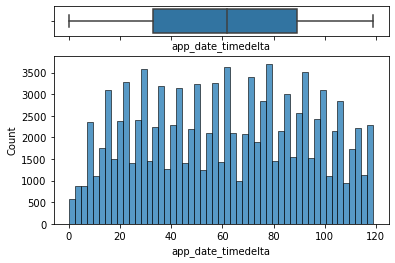

In [369]:
# ну и поссмотрим на результат нашей работы 
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(data = data, x = 'app_date_timedelta', ax=ax_box)
sns.histplot(data = data, x = 'app_date_timedelta', ax=ax_hist)
 
print(outlier_detect(data,data['app_date_timedelta']))

### Education

<AxesSubplot:xlabel='education', ylabel='Count'>

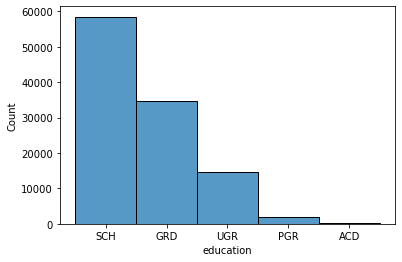

In [370]:
# посмотрим на распределение признака
sns.histplot(data = data, x = 'education')

Выглядит все достаточно логично, теперь давайте конвертируем всё в числа(ведь алгоритмы не могу работать с буквами)

In [371]:
education_dict = {'SCH': 1, 'GRD': 2, 'UGR': 3, 'PGR': 4, 'ACD': 5}

data['education'] = data['education'].map(education_dict)

### Gender

<AxesSubplot:xlabel='sex', ylabel='Count'>

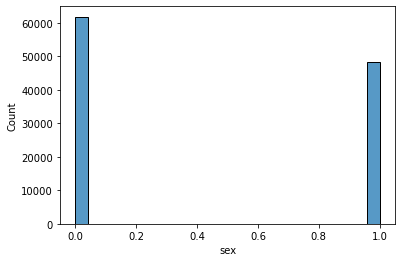

In [372]:
# посмотрим на распределение признака
sns.histplot(data = data, x = 'sex')

### Age

Lower Range:
3.0
Upper Range:
75.0
Lower Outliers:
0
Upper Outliers:
0
None


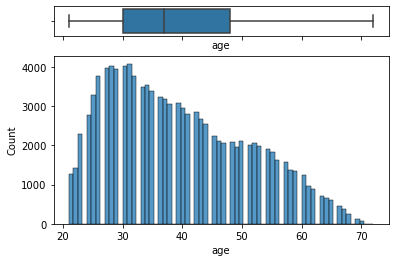

In [373]:
# посмотрим на распределение признака
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(data = data, x = 'age', ax=ax_box)
sns.histplot(data = data, x = 'age', ax=ax_hist)
 
print(outlier_detect(data,data['age']))

Так, это придется прологарфмировать, но исхдя из графика, люди 30 +/- наиболее охотно делают какие-либо крупные покупки

<AxesSubplot:xlabel='age', ylabel='Count'>

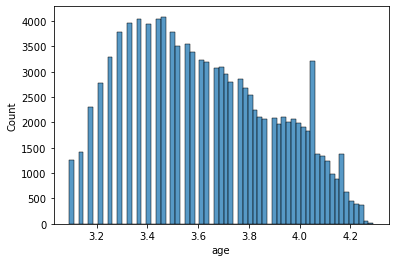

In [374]:
# логарифмируем

sns.histplot(data = data, x = np.log(data['age'] + 1))

Распределение выглядит нормально, тогда оставим логарифм

In [375]:
data['age'] = np.log(data['age'] + 1)
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample,education_nan,app_date_timedelta
0,25905,2014-02-01,1,1,4.143135,1,1,0,0,-2.008753,1,50,1,2,18000,4,1,0,0.0,1,0,31
1,63161,2014-03-12,1,0,4.094345,0,0,0,0,-1.532276,3,50,2,3,19000,4,1,0,0.0,1,0,70
2,25887,2014-02-01,1,1,3.258097,1,0,2,0,-1.408142,1,80,1,2,30000,1,4,1,0.0,1,0,31
3,16222,2014-01-23,1,0,3.988984,0,0,0,0,-2.057471,2,50,2,3,10000,1,3,0,0.0,1,0,22
4,101655,2014-04-18,2,1,3.891820,0,0,0,1,-1.244723,1,60,2,3,30000,1,4,1,0.0,1,0,107


Lower Range:
2.7472375640469258
Upper Range:
4.5785699385488465
Lower Outliers:
0
Upper Outliers:
0


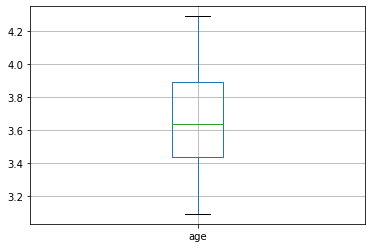

In [376]:
# на всякий случай посотрим боксплот и поищем выбросы 
data.boxplot(column=['age'])
outlier_detect(data,data['age'])

### Car

<AxesSubplot:xlabel='car', ylabel='Count'>

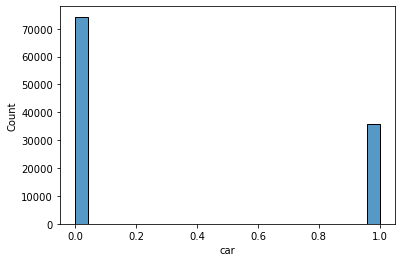

In [377]:
# посмотрим на распределение признака
sns.histplot(data = data, x = 'car')

У большей части клиентов нет машины

### Foreign-made car

<AxesSubplot:xlabel='car_type', ylabel='Count'>

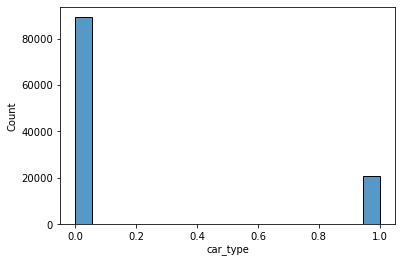

In [378]:
# посмотрим на распределение признака
sns.histplot(data = data, x = 'car_type')

У большинства автовладельцев из этого набора данных есть автомобили отечественного производства

### Declined applications

Lower Range:
0.0
Upper Range:
0.0
Lower Outliers:
0
Upper Outliers:
18677
None


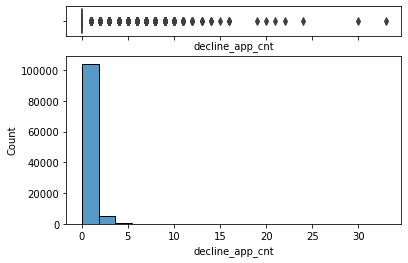

In [379]:
# посмотрим на распределение признака, и на наличие выбросов
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(data = data, x = 'decline_app_cnt', ax=ax_box)
sns.histplot(data = data, x = 'decline_app_cnt', ax=ax_hist)
 
print(outlier_detect(data,data['decline_app_cnt']))

Подавляющее большинство заемщиков не отклонили заявки, поэтому наша функция рассматривает значительную часть результатов как выбросы. Попробуем исправить ситуацию, взяв логарифм столбца.

Lower Range:
0.0
Upper Range:
0.0
Lower Outliers:
0
Upper Outliers:
18677
None


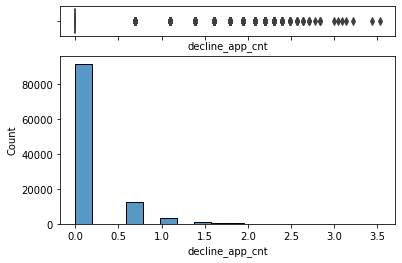

In [380]:
data['decline_app_cnt'] = np.log(data['decline_app_cnt'] + 1)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(data = data, x = 'decline_app_cnt', ax=ax_box)
sns.histplot(data = data, x = 'decline_app_cnt', ax=ax_hist)
 
print(outlier_detect(data,data['decline_app_cnt']))

Ситуция лучше не стала :-(

### Good work

<AxesSubplot:xlabel='good_work', ylabel='Count'>

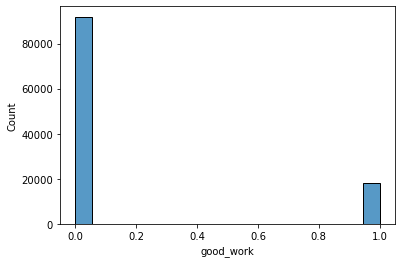

In [381]:
# распределение признака
sns.histplot(data = data, x = 'good_work')

У большей части клиентов из датасета хорошооплачиваемая работа

### BKI score

Lower Range:
-3.299251946250001
Upper Range:
-0.5290698762499992
Lower Outliers:
82
Upper Outliers:
436
None


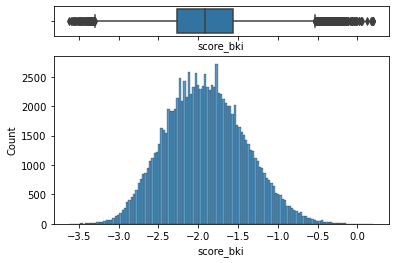

In [382]:
# распределение
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
sns.boxplot(data = data, x = 'score_bki', ax=ax_box)
sns.histplot(data = data, x = 'score_bki', ax=ax_hist)

# наличие выбросов
print(outlier_detect(data,data['score_bki']))

Распределение нормальное и не столь много выбросов

### BKI requests

Lower Range:
-4.5
Upper Range:
7.5
Lower Outliers:
0
Upper Outliers:
2636
None


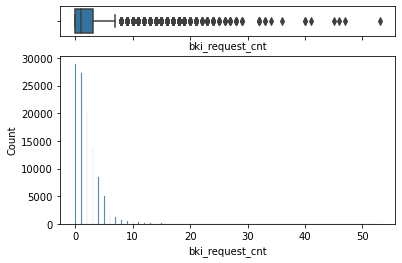

In [383]:
# распределение
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
sns.boxplot(data = data, x = 'bki_request_cnt', ax=ax_box)
sns.histplot(data = data, x = 'bki_request_cnt', ax=ax_hist)

# выбросы
print(outlier_detect(data,data['bki_request_cnt']))

<AxesSubplot:>

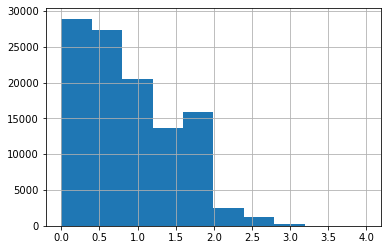

In [384]:
# прологарифмируем
np.log(data['bki_request_cnt'] + 1).hist()

Lower Range:
-2.0794415416798357
Upper Range:
3.465735902799726
Lower Outliers:
0
Upper Outliers:
15
None


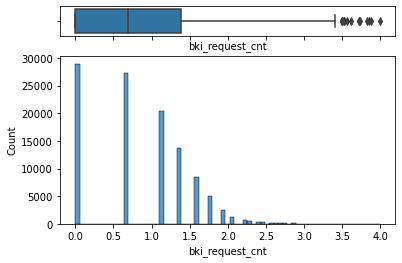

In [385]:
# оставим логарифм
data['bki_request_cnt'] = np.log(data['bki_request_cnt'] + 1)
# проверим распределение
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
sns.boxplot(data = data, x = 'bki_request_cnt', ax=ax_box)
sns.histplot(data = data, x = 'bki_request_cnt', ax=ax_hist)
# выбросы
print(outlier_detect(data,data['bki_request_cnt']))

Количество выбросов упало с 2636 до 15

### Region rating

<AxesSubplot:xlabel='region_rating', ylabel='Count'>

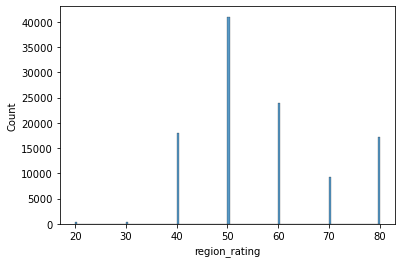

In [386]:
# распределение

sns.histplot(data = data, x = 'region_rating')

### Home address

<AxesSubplot:xlabel='home_address', ylabel='Count'>

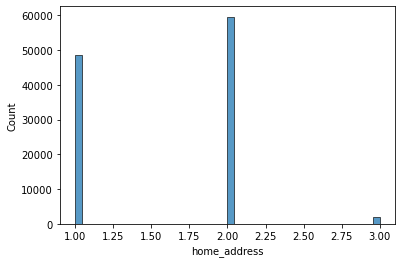

In [387]:
# распределение
sns.histplot(data = data, x = 'home_address')

### Work address

<AxesSubplot:xlabel='work_address', ylabel='Count'>

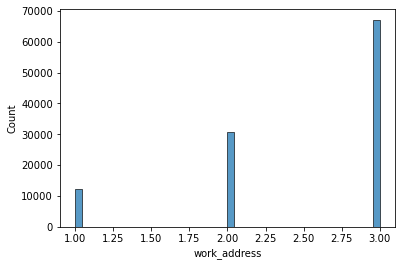

In [388]:
# распределение

sns.histplot(data = data, x = 'work_address')

## 3.14 Income

Lower Range:
-22000.0
Upper Range:
90000.0
Lower Outliers:
0
Upper Outliers:
7000
None


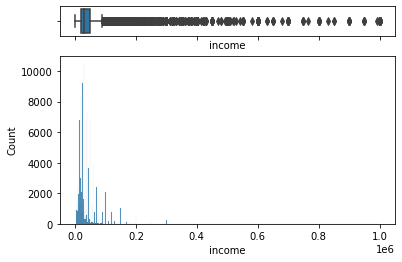

In [389]:
# распределение
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
sns.boxplot(data = data, x = 'income', ax=ax_box)
sns.histplot(data = data, x = 'income', ax=ax_hist)

# выбросы
print(outlier_detect(data,data['income']))

Lower Range:
8.590378193705899
Upper Range:
12.092136480586621
Lower Outliers:
875
Upper Outliers:
1734
None


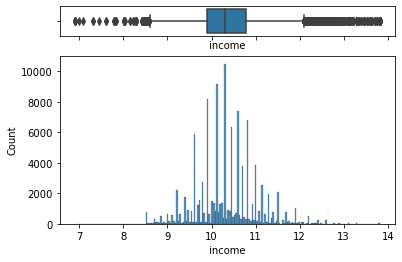

In [390]:
# логарифмируем
data['income'] = np.log(data['income'] + 1)
# распределение
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(data = data, x = 'income', ax=ax_box)
sns.histplot(data = data, x = 'income', ax=ax_hist)
 
print(outlier_detect(data,data['income']))

Количество выбросов упалос с 7000 до 2609, да и в целом логарифмизация поправила и нормализовала ситуацию

### SNA

<AxesSubplot:xlabel='sna', ylabel='Count'>

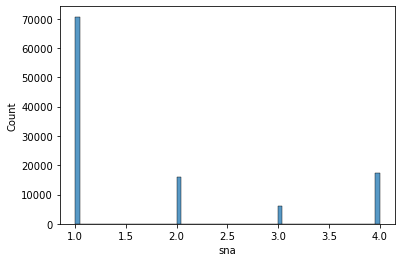

In [391]:
# распределение

sns.histplot(data = data, x = 'sna')

### First time

<AxesSubplot:xlabel='first_time', ylabel='Count'>

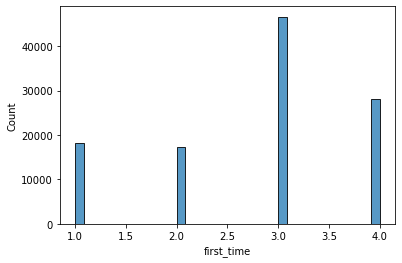

In [392]:
# распределение

sns.histplot(data = data, x = 'first_time')

### Foreign passport

<AxesSubplot:xlabel='foreign_passport', ylabel='Count'>

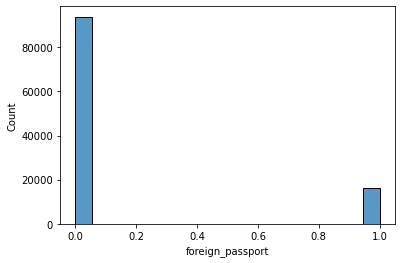

In [393]:
# распределение

sns.histplot(data = data, x = 'foreign_passport')

Большая часть клиентов не имеет загранпаспорта

### Default

<AxesSubplot:xlabel='default', ylabel='Count'>

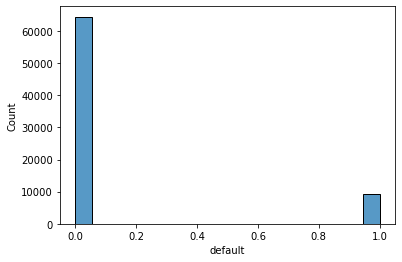

In [394]:
# распределение
sns.histplot(data = data, x = 'default')

Распределение в нашем наборе данных сильно смещено в сторону клиентов, у которых не было дефолта

## Feature importance

<AxesSubplot:>

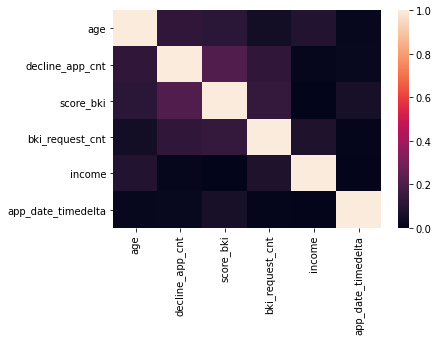

In [395]:
# помотрим на матрицу корреляций
data_train_temp = data[data['sample']==1]
sns.heatmap(data_train_temp[num_cols].corr().abs(), vmin=0, vmax=1)

In [396]:
data_train_temp[num_cols].corr().abs().sort_values(by='decline_app_cnt', ascending=False)

,age,decline_app_cnt,score_bki,bki_request_cnt,income,app_date_timedelta
decline_app_cnt,0.127734,1.000000,0.210090,0.125163,0.013868,0.022662
score_bki,0.109971,0.210090,1.000000,0.139622,0.002860,0.063605
age,1.000000,0.127734,0.109971,0.049327,0.092586,0.017071
bki_request_cnt,0.049327,0.125163,0.139622,1.000000,0.081019,0.009758
app_date_timedelta,0.017071,0.022662,0.063605,0.009758,0.005197,1.000000
income,0.092586,0.013868,0.002860,0.081019,1.000000,0.005197


Между признаками нет особо сильной корреляции, кроме количества отклоненных заявок и показателем BKI. Да и там она не такая уж и большая

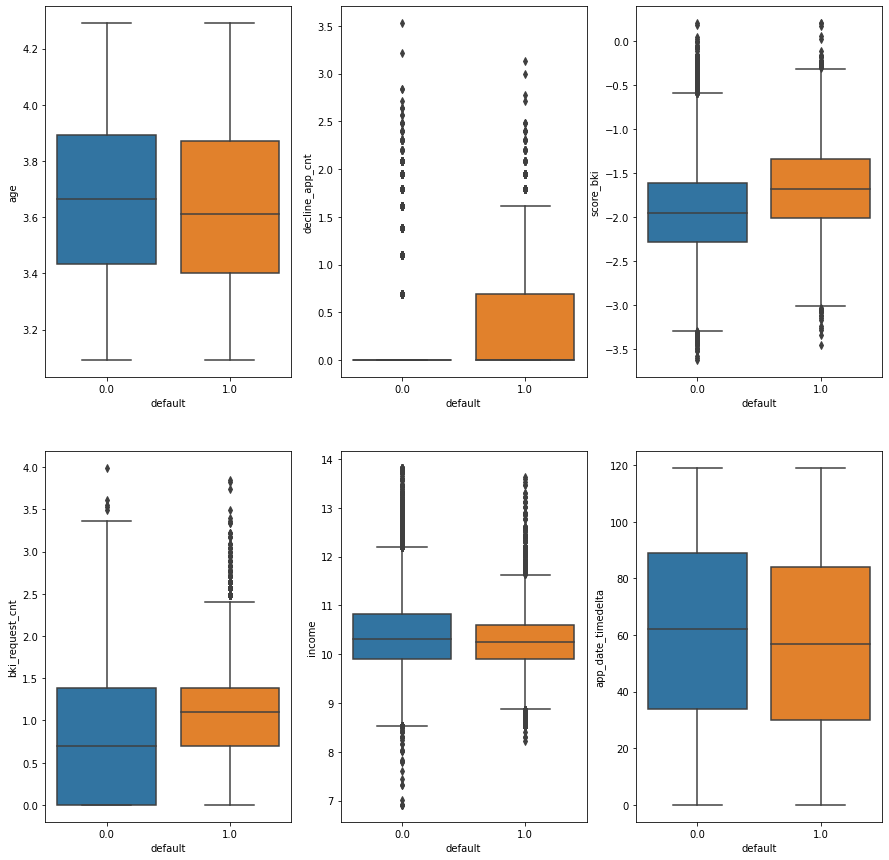

In [397]:
# распределение
fig, axes = plt.subplots(2, 3, figsize=(15, 15))
axes = axes.flatten()
for i in range(len(num_cols)):
    sns.boxplot(x="default", y=num_cols[i], data=data_train_temp, ax=axes[i])

Дефолтные клиенты в среднем моложе и меньше зарабатывают, имеют больше заявок и отказов от банка, но при этом имеют более высокий рейтинг BKI.

<AxesSubplot:>

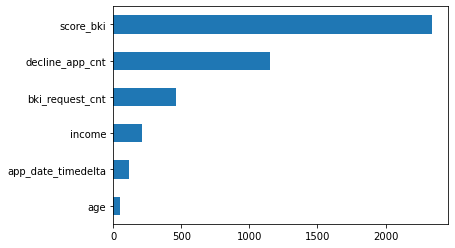

In [398]:
# поищем наиболее важные признаки
imp_num = Series(f_classif(data_train_temp[num_cols], 
                           data_train_temp['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

<AxesSubplot:>

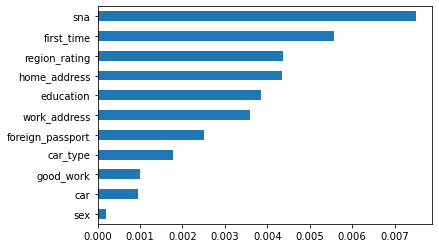

In [399]:
# поищем наиболее важные признаки
imp_cat = Series(mutual_info_classif(
    data_train_temp[bin_cols + cat_cols], data_train_temp['default'], 
    discrete_features =True
), index = bin_cols + cat_cols)

imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Из числовых переменных наиболее важной является количество отказов и BKI-рейтинг. Из категорийных и бинарных наиболее важной является уровень связи с другими клиентами

# Data preprocessing

## Standardization

In [400]:
# стандартизируем данные
ss = StandardScaler()
data[num_cols] = pd.DataFrame(ss.fit_transform(data[num_cols]),columns = data[num_cols].columns)

In [401]:
# посмотрим на данные
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   client_id           110148 non-null  int64         
 1   app_date            110148 non-null  datetime64[ns]
 2   education           110148 non-null  int64         
 3   sex                 110148 non-null  int32         
 4   age                 110148 non-null  float64       
 5   car                 110148 non-null  int32         
 6   car_type            110148 non-null  int32         
 7   decline_app_cnt     110148 non-null  float64       
 8   good_work           110148 non-null  int64         
 9   score_bki           110148 non-null  float64       
 10  bki_request_cnt     110148 non-null  float64       
 11  region_rating       110148 non-null  int64         
 12  home_address        110148 non-null  int64         
 13  work_address        110148 no

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample,education_nan,app_date_timedelta
0,25905,2014-02-01,1,1,1.714029,1,1,-0.418815,0,-0.208688,-0.281790,50,1,2,-0.786080,4,1,0,0.0,1,0,-0.934391
1,63161,2014-03-12,1,0,1.542867,0,0,-0.418815,0,0.745419,0.770563,50,2,3,-0.708472,4,1,0,0.0,1,0,0.281474
2,25887,2014-02-01,1,1,-1.390791,1,0,2.621662,0,0.993988,-0.281790,80,1,2,-0.052834,1,4,1,0.0,1,0,-0.934391
3,16222,2014-01-23,1,0,1.173250,0,0,-0.418815,0,-0.306243,0.333797,50,2,3,-1.629771,1,3,0,0.0,1,0,-1.214975
4,101655,2014-04-18,2,1,0.832388,0,0,-0.418815,1,1.321223,-0.281790,60,2,3,-0.052834,1,4,1,0.0,1,0,1.434987


## Используем RandomForestRegressor чтобы заполнить пропущенные значения в признаке education

In [402]:
# подготовка данных и обучение модели
data_temp = data.drop(['sample', 'client_id', 'app_date', 'default'], axis=1)
data_education_nan = data_temp[data_temp['education_nan']==1]
data_no_nan = data_temp[data_temp['education_nan']==0]
y = data_no_nan['education'].values
X = data_no_nan.drop(['education'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = random_seed)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state = random_seed)
model.fit(X_train, y_train)
y_pred = np.round(model.predict(X_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [403]:
# предсказание значений
predict = np.round(model.predict(data_education_nan.drop(['education'], axis=1)))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [404]:
# добавление предсказанных значений в датасет
index_education_nan = data[data['education_nan']==1].index
data.loc[index_education_nan,'education'] = predict

## One-hot encoding

In [405]:
# перекодируем в dummy-переменные
data = pd.get_dummies(data, prefix=cat_cols, columns=cat_cols)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 42 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   client_id           110148 non-null  int64         
 1   app_date            110148 non-null  datetime64[ns]
 2   sex                 110148 non-null  int32         
 3   age                 110148 non-null  float64       
 4   car                 110148 non-null  int32         
 5   car_type            110148 non-null  int32         
 6   decline_app_cnt     110148 non-null  float64       
 7   good_work           110148 non-null  int64         
 8   score_bki           110148 non-null  float64       
 9   bki_request_cnt     110148 non-null  float64       
 10  income              110148 non-null  float64       
 11  foreign_passport    110148 non-null  int32         
 12  default             73799 non-null   float64       
 13  sample              110148 no

In [406]:
# посмотрим на данные
data.head()

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,foreign_passport,default,sample,education_nan,app_date_timedelta,education_1.0,education_2.0,education_3.0,education_4.0,education_5.0,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4
0,25905,2014-02-01,1,1.714029,1,1,-0.418815,0,-0.208688,-0.281790,-0.786080,0,0.0,1,0,-0.934391,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0
1,63161,2014-03-12,0,1.542867,0,0,-0.418815,0,0.745419,0.770563,-0.708472,0,0.0,1,0,0.281474,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0
2,25887,2014-02-01,1,-1.390791,1,0,2.621662,0,0.993988,-0.281790,-0.052834,1,0.0,1,0,-0.934391,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,1
3,16222,2014-01-23,0,1.173250,0,0,-0.418815,0,-0.306243,0.333797,-1.629771,0,0.0,1,0,-1.214975,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0
4,101655,2014-04-18,1,0.832388,0,0,-0.418815,1,1.321223,-0.281790,-0.052834,1,0.0,1,0,1.434987,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1


# Model

In [407]:
# разделим датасет
data_train = data.query('sample == 1').drop(['sample', 'client_id', 'app_date'], axis=1)
data_test = data.query('sample == 0').drop(['sample', 'client_id', 'app_date'], axis=1)

In [408]:
# тренировка и приедсказание
X = data_train.drop(['default'], axis=1)
y = data_train['default'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random_seed)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

C:\Users\rebvj\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Оценка модели

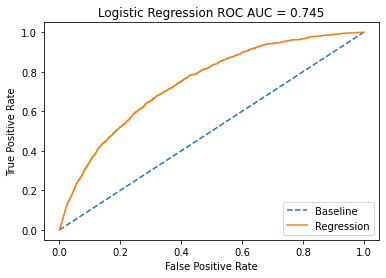

In [409]:
# построим кривую ROC-показателя
probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

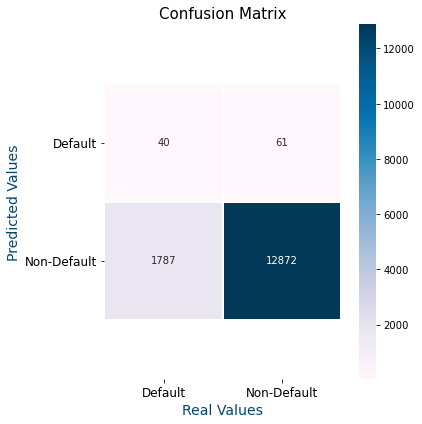

In [410]:
# посмотрим на матрицу ошибок
show_confusion_matrix(y_test, y_pred)

In [411]:
# проверим наши метрики
all_metrics(y_test, y_pred, y_pred_prob)

,Value,Description
"Positive, P",1827.000000,default
"Negative, N",12933.000000,non-default
"True Positive, TP",40.000000,correctly identified default
"True Negative, TN",12872.000000,correctly identified non-default
"False Positive, FP",61.000000,incorrectly identified default
"False Negative, FN",1787.000000,incorrectly identified non-default
Accuracy,0.874797,Accuracy=(TP+TN)/(P+N)
Precision,0.396040,Precision = TP/(TP+FP)
Recall,0.021894,Recall = TP/P
F1-score,0.041494,Harmonical mean of Precision и Recall


ROC/AUC - показатели достаточно хороши, но матрица ошибок показывает что модель предсказывает дефолт очень плохо. Из 1827 дефолтов только 40 были корректно предсказаны, они же ~2.2%(очень низкий Recall - показатель). Тогда поиграемся с гиперпараметрами.

# Regularization

In [412]:
model = LogisticRegression(random_state=random_seed)

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_

best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

preds = model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))

C:\Users\rebvj\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.34026848        nan
 0.34026848        nan 0.05540439 0.05541069        nan 0.05516422
 0.05516422 0.05540439 0.05541069        nan 0.05516422 0.05516422
 0.34019134 0.34011218 0.34012411 0.3402254  0.34021312 0.34019134
 0.34011218 0.34012411 0.3402254  0.34021312 0.05540439 0.05539689
 0.05540439 0.05540439 0.05540439 0.05539689 0.05540439 0.05540439
 0.34017932 0.34016906 0.3401334  0.3402006  0.34017932 0.34016906
 0.3401334  0.3402006 ]
  warnings.warn(


	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l1'
	random_state: 42
	solver: 'liblinear'
	tol: 0.001
	verbose: 0
	warm_start: False
Accuracy: 0.6711
Precision: 0.2265
Recall: 0.6864
F1: 0.3406


Обучим модель на наших гиперпараметрах

In [413]:
# Обучение и предсказание
model = LogisticRegression(random_state=random_seed, 
                           C=1, 
                           class_weight='balanced', 
                           dual=False, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           l1_ratio=None, 
                           multi_class='auto', 
                           n_jobs=None, 
                           penalty='l1', 
                           solver='liblinear', 
                           verbose=0, 
                           warm_start=False)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

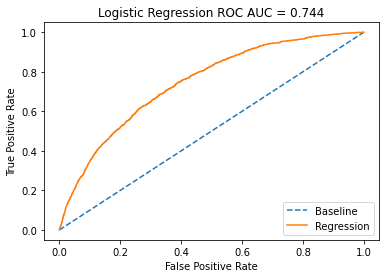

In [414]:
# построим ROC - кривую
probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

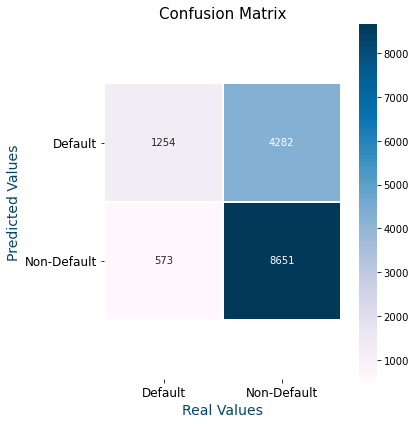

In [415]:
# проверим матрицу оштбок
show_confusion_matrix(y_test, y_pred)

In [416]:
# и проверим наши метрики
all_metrics(y_test, y_pred, y_pred_prob)

,Value,Description
"Positive, P",1827.000000,default
"Negative, N",12933.000000,non-default
"True Positive, TP",1254.000000,correctly identified default
"True Negative, TN",8651.000000,correctly identified non-default
"False Positive, FP",4282.000000,incorrectly identified default
"False Negative, FN",573.000000,incorrectly identified non-default
Accuracy,0.671070,Accuracy=(TP+TN)/(P+N)
Precision,0.226517,Precision = TP/(TP+FP)
Recall,0.686371,Recall = TP/P
F1-score,0.340622,Harmonical mean of Precision и Recall


Recall повысился с 2 до 68%. Precision стал ниже, потому что теперь наш алгоритм обнаруживает дефолты с большей вероятностью, даже если их нет. F1 - score между отзывами и точностью тоже снизился. Тем не менее, качество модели с точки зрения банка, повысилось.
Отзыв увеличился с 2 до 68 процентов. К сожалению, точность снизилась, потому что теперь наш алгоритм с большей вероятностью обнаруживает значения по умолчанию, даже если их нет. Среднее гармоническое значение между отзывами и точностью (оценка F1) также снизилось. Однако с точки зрения потребителя, то есть банка, можно сказать, что качество модели повысилось. Однако есть еще кое-что для улучшения.

# Submission

In [417]:
data_train = data.query('sample == 1').drop(['sample', 'client_id', 'app_date'], axis=1)
data_test = data.query('sample == 0').drop(['sample', 'client_id', 'app_date'], axis=1)

In [418]:
X_train = data_train.drop(['default'], axis=1)
y_train = data_train['default'].values
X_test = data_test.drop(['default'], axis=1)

In [419]:
model = LogisticRegression(random_state=random_seed, 
                           C=1, 
                           class_weight='balanced', 
                           dual=False, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           l1_ratio=None, 
                           multi_class='auto', 
                           n_jobs=None, 
                           penalty='l1', 
                           solver='liblinear', 
                           verbose=0, 
                           warm_start=False,
                           max_iter=1000)

model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='liblinear')

In [420]:
y_pred_prob = model.predict_proba(X_test)[:,1]

In [421]:
submit = pd.DataFrame(data.query('sample == 0')['client_id'])
submit['default'] = y_pred_prob
submit.to_csv('submission3.csv', index=False)

In [422]:
submit.head()

,client_id,default
73799,74835,0.201623
73800,17527,0.793670
73801,75683,0.306250
73802,26883,0.407681
73803,28862,0.136402
